In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel, cmdstan_path, set_cmdstan_path
import os

# I am using a version of stan for python names CmdStanPy
# To install it please see https://cmdstanpy.readthedocs.io/en/stable-0.9.65/getting_started.html




In [3]:
sns.set_theme(style="darkgrid")

In [4]:
set_cmdstan_path( os.path.join('/Users/javier/.cmdstan/cmdstan-2.27.0'))
cmdstan_path()

'/Users/javier/.cmdstan/cmdstan-2.27.0'

In [5]:
# SEE:
# https://arxiv.org/pdf/1903.00423v3.pdf Contemporary statistical inference for infectious disease models using Stan
# https://arxiv.org/pdf/2006.02985.pdf Bayesian workflow for disease transmission modeling in Stan
# MCMC HMC Hamiltonian Monte Carlo ---> STAN


#----- Problem

# Influenza A H1N1  Bristish Boarding School 1978 22 enero-04 de febrero
# N=763 students, 512 got sick
#

# Capitulo 9 De Vries et al. (2006) 
# Available in RECON https://www.repidemicsconsortium.org 


# Likelihood: y_t ~ Poisson(I_t) 
# Only infected are observed

# Prioris: 
#    beta ~ lognormal(0,1)
#    gamma ~ Gamma(0.02, 0.004 ) Tiempo medio de infeccion sea 5 dias
#    S(0)/N ~ beta( 0.5, 0.5 ) 


# A very good example about ODEs in Stan is the following:
# https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html



In [6]:
# Observed data

yt=np.array(   [3,8,28,76,222,293, 257, 237, 192, 126, 70, 28, 12, 5]    )
t=np.arange(1,15,1)

Text(0.5, 1.0, 'I(t) UK 1978')

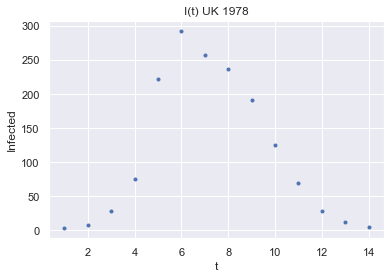

In [7]:
plt.plot(t,yt, '.')
plt.xlabel('t')
plt.ylabel('Infected')
plt.title('I(t) UK 1978')

In [8]:
N= 763 #Population size
N_t= len(yt)

In [9]:
stan_data = {'t0': 0, 'N_t':N_t, 'ts':t, 'yt': yt, 'N':N} #Stan data is a dictionary

In [10]:
# This is different from when we use PyStan. This command is used to compile the model.
sm = CmdStanModel(stan_file= 'EBSSIR.stan', cpp_options={"STAN_THREADS": True}); # compile model

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/javier/EBSSIR


In [11]:
# Perform sampling
fit = sm.sample(data= stan_data, chains=4, output_dir= '.', iter_sampling=4000, seed=1,  ); # perform sampling

#This might take a little bit of time. If you see the file named EBSSIR.stan then you can see the code used for the model. 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [12]:
print(fit) 

#Different files are generated for each chain and saved in our directory. 

CmdStanMCMC: model=EBSSIR chains=4['method=sample', 'num_samples=4000', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/Users/javier/EBSSIR-202108212213-1.csv
	/Users/javier/EBSSIR-202108212213-2.csv
	/Users/javier/EBSSIR-202108212213-3.csv
	/Users/javier/EBSSIR-202108212213-4.csv
 output_files:
	/Users/javier/EBSSIR-202108212213-1-stdout.txt
	/Users/javier/EBSSIR-202108212213-2-stdout.txt
	/Users/javier/EBSSIR-202108212213-3-stdout.txt
	/Users/javier/EBSSIR-202108212213-4-stdout.txt


In [13]:
fit.summary()
# summary of the quantities that were estimated. lp__ stands for log posterior.
# Notice we also have other variables such as Shat,..., Rrep. This are 'transformed parameters' or 'generated quantities'


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,6500.00000,0.016000,1.20000,6500.00000,6500.00000,6500.0000,5800.0,110.0,1.0
beta,1.90000,0.000710,0.05300,1.80000,1.90000,2.0000,5600.0,100.0,1.0
gamma,0.48000,0.000130,0.01100,0.46000,0.48000,0.5000,7700.0,140.0,1.0
i0,0.00055,0.000002,0.00014,0.00035,0.00054,0.0008,5700.0,100.0,1.0
"Shat[1,1]",761.00000,0.005600,0.42000,760.00000,761.00000,762.0000,5773.0,106.0,1.0
...,...,...,...,...,...,...,...,...,...
Rrep[10],631.00000,0.071000,5.90000,621.00000,631.00000,641.0000,6916.0,126.0,1.0
Rrep[11],671.00000,0.060000,4.80000,663.00000,671.00000,679.0000,6537.0,120.0,1.0
Rrep[12],697.00000,0.050000,4.00000,690.00000,697.00000,703.0000,6303.0,115.0,1.0


In [14]:
# We have 4000 observations of 4 chains and 99 parameters were estimated! Notice that out of the 16000 we have an eff sample size of around 5-7k

fit.draws().shape


(4000, 4, 99)

In [15]:
theta=fit.draws_pd() #get the posterior draws

In [16]:
theta.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'beta', 'gamma', 'i0', 'Shat[1,1]',
       'Shat[2,1]', 'Shat[3,1]', 'Shat[4,1]', 'Shat[5,1]', 'Shat[6,1]',
       'Shat[7,1]', 'Shat[8,1]', 'Shat[9,1]', 'Shat[10,1]', 'Shat[11,1]',
       'Shat[12,1]', 'Shat[13,1]', 'Shat[14,1]', 'Shat[1,2]', 'Shat[2,2]',
       'Shat[3,2]', 'Shat[4,2]', 'Shat[5,2]', 'Shat[6,2]', 'Shat[7,2]',
       'Shat[8,2]', 'Shat[9,2]', 'Shat[10,2]', 'Shat[11,2]', 'Shat[12,2]',
       'Shat[13,2]', 'Shat[14,2]', 'Shat[1,3]', 'Shat[2,3]', 'Shat[3,3]',
       'Shat[4,3]', 'Shat[5,3]', 'Shat[6,3]', 'Shat[7,3]', 'Shat[8,3]',
       'Shat[9,3]', 'Shat[10,3]', 'Shat[11,3]', 'Shat[12,3]', 'Shat[13,3]',
       'Shat[14,3]', 'theta[1]', 'theta[2]', 'x0[1]', 'x0[2]', 'x0[3]',
       'Srep[1]', 'Srep[2]', 'Srep[3]', 'Srep[4]', 'Srep[5]', 'Srep[6]',
       'Srep[7]', 'Srep[8]', 'Srep[9]', 'Srep[10]', 'Srep[11]', 'Srep[12]',
       'Srep[13]', 'Srep[14]', 'Irep[1]', 

In [17]:
# posterior predictive observations for S(t), I(t), R(t)
Srep=theta.loc[:, 'Srep[1]':'Srep[14]']
Irep=theta.loc[:, 'Irep[1]':'Irep[14]']
Rrep=theta.loc[:, 'Rrep[1]':'Rrep[14]']

Text(0.5, 1.0, 'S(t)')

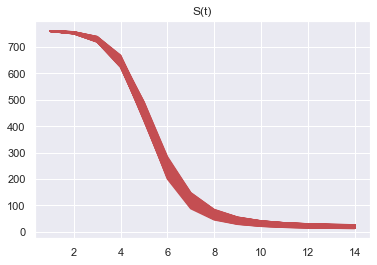

In [18]:
for i in range(0,500):
    plt.plot(t,pd.DataFrame.to_numpy(Srep.sample(1)).transpose(), 'r')
plt.title('S(t)')

Text(0.5, 1.0, 'I(t)')

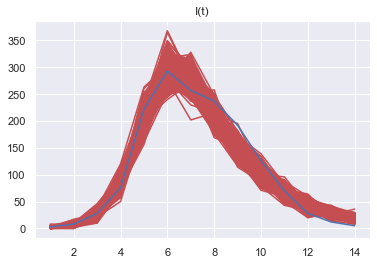

In [19]:
for i in range(0,500):
    plt.plot(t,pd.DataFrame.to_numpy(Irep.sample(1)).transpose(), 'r')
plt.plot(t,yt)
plt.title('I(t)')

Text(0.5, 1.0, 'R(t)')

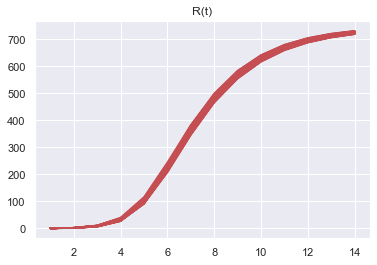

In [20]:
for i in range(0,100):
    plt.plot(t,pd.DataFrame.to_numpy(Rrep.sample(1)).transpose(), 'r')
plt.title('R(t)')

In [21]:
beta=theta.loc[:,'beta']
gamma= theta.loc[:,'gamma'], 
i0= theta.loc[:,'i0']

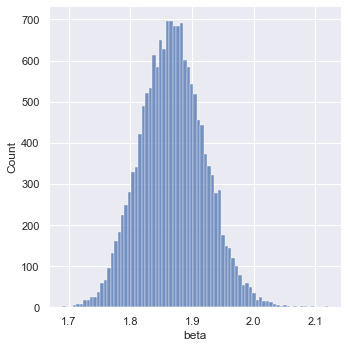

In [22]:
sns.displot(beta)

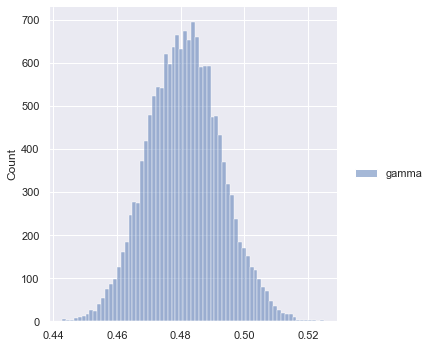

In [23]:
sns.displot(gamma)

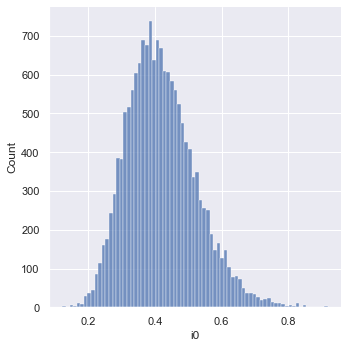

In [24]:
sns.displot(i0*N)

In [26]:
results=theta.loc[:,['beta', 'gamma', 'i0']]
results['r0']= theta['beta']/ theta['gamma']


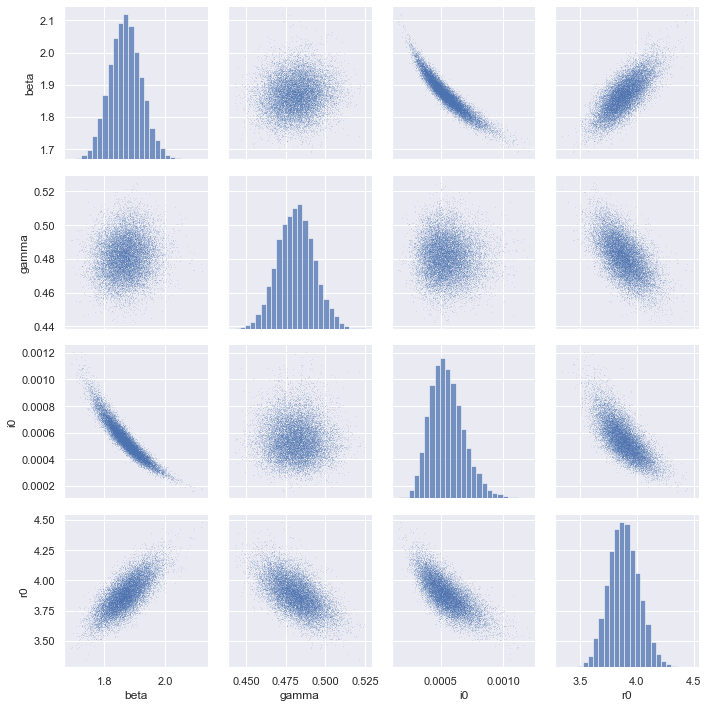

In [27]:
sns.pairplot(results, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=25) )
plt.tight_layout()
